In [29]:
import h5py
import importlib
import os
import sys
from collections import defaultdict
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

from genomic_utils.variant import Variant

import driver_utils

importlib.reload(driver_utils)

sys.path += ["../", "../../predixcan_lite"]
import evaluation_utils
import utils

In [30]:
FUSION_WEIGHTS_DIR = "../../fusion/WEIGHTS"
FUSION_PREDS_DIR = "../../fusion/preds"
FUSION_MODELS = ["top1", "lasso", "enet", "blup", "bslmm"]

BASELINE_ENFORMER_PREDS_PATH = "../../baseline/baseline_enformer.384_bins.rc.csv"
BASELINE_ENFORMER_ISM_DIR = "../ISM/baseline.384_bins/"

FINETUNED_ENFORMER_PREDS_PATH = "/data/yosef3/scratch/ruchir/finetuning-enformer/saved_models/regression_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3/test_preds.npz"
FINETUNED_ENFORMER_ISM_DIR = "/data/yosef3/scratch/ruchir/finetuning-enformer/saved_models/regression_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3/ism"

FIGURES_DIR = "../figures"

In [31]:
GEUVADIS_COUNTS_PATH = (
    "../../process_geuvadis_data/log_tpm/corrected_log_tpm.annot.csv.gz"
)
TRAIN_H5_PATH = "../../finetuning/data/h5_bins_384_chrom_split/train.h5"
TEST_H5_PATH = "../../finetuning/data/h5_bins_384_chrom_split/test.h5"
CONTEXT_SIZE = 128 * 384

# Helper functions

### Load train genes

In [32]:
def get_training_genes():
    gene_to_class_map = evaluation_utils.get_gene_to_class_map()
    train_genes = {g for g, c in gene_to_class_map.items() if c != "unseen"}
    assert len(train_genes) == 400
    return train_genes

### Load samples

In [33]:
def get_samples_per_gene(h5_path: str) -> dict[str, set]:
    samples_per_gene = defaultdict(set)
    with h5py.File(h5_path, "r") as f:
        genes = f["genes"][:].astype(str)
        samples = f["samples"][:].astype(str)
        for (gene, sample) in zip(genes, samples):
            samples_per_gene[gene].add(sample)
    return samples_per_gene

### Compute allele frequency

In [34]:
def compute_aaf(geno_mtx: pd.DataFrame) -> pd.Series:
    ac = geno_mtx.applymap(utils.convert_to_dosage).sum(axis=1)
    an = geno_mtx.applymap(utils.count_total_alleles).sum(axis=1)
    aaf = ac / an
    return aaf

### Load model weights

In [35]:
def load_fusion_weights(gene: str, model: str) -> pd.DataFrame:
    df = pd.read_csv(
        os.path.join(FUSION_WEIGHTS_DIR, f"{gene}.{model}.weights.txt"),
        sep="\t",
        header=None,
        names=["id", "alt", "ref", "weight"],
    )
    df["weight"] = df["weight"].astype(float)
    if df.isnull().values.any():
        weights_path = f"{gene}.{model}.weights.txt"
        print(f"WARNING: NaNs detected in {weights_path}")
        df = df.dropna()

    df["chrom"] = df["id"].apply(lambda x: x.split("_")[1])
    df["pos"] = df["id"].apply(lambda x: int(x.split("_")[2]))
    df["variant"] = [
        Variant(chrom, pos, ref, alt)
        for (chrom, pos, ref, alt) in zip(df["chrom"], df["pos"], df["ref"], df["alt"])
    ]
    df = df.set_index("variant")
    df = df[["weight"]]

    # We removed NaNs earlier, but let's make sure...
    assert df["weight"].notnull().all()
    assert df["weight"].apply(lambda x: isinstance(x, float)).all()
    return df


def load_enformer_isms(ism_dir: str, gene: str) -> pd.DataFrame:
    df = pd.read_csv(os.path.join(ism_dir, f"{gene}.csv"), header=0, index_col=0)
    df.index = df.index.map(Variant.create_from_str)
    return df

### Load model preds

In [36]:
def load_fusion_model_preds(model: str) -> pd.DataFrame:
    preds_path = os.path.join(FUSION_PREDS_DIR, f"{model}.csv")
    return pd.read_csv(preds_path, index_col=0)


def load_baseline_enformer_preds() -> pd.DataFrame:
    return pd.read_csv(BASELINE_ENFORMER_PREDS_PATH, index_col=0)


def load_finetuned_enformer_preds() -> pd.DataFrame:
    return evaluation_utils.load_finetuned_model_predictions(
        FINETUNED_ENFORMER_PREDS_PATH
    )

# Fetch drivers

In [37]:
training_genes = get_training_genes()
training_samples_per_gene = get_samples_per_gene(TRAIN_H5_PATH)
test_samples_per_gene = get_samples_per_gene(TEST_H5_PATH)

preds_per_model = {model: load_fusion_model_preds(model) for model in FUSION_MODELS}
preds_per_model["baseline"] = load_baseline_enformer_preds()
preds_per_model["finetuned"] = load_finetuned_enformer_preds()

counts_df = pd.read_csv(GEUVADIS_COUNTS_PATH, index_col="our_gene_name")

In [38]:
results = defaultdict(list)

for gene in tqdm(training_genes):
    train_samples = sorted(training_samples_per_gene[gene])
    test_samples = sorted(test_samples_per_gene[gene])

    # Load dosages
    geno_mtx = utils.get_genotype_matrix(
        counts_df.loc[gene, "Chr"], counts_df.loc[gene, "Coord"], CONTEXT_SIZE
    )
    dosages_mtx = geno_mtx.applymap(utils.convert_to_dosage)

    # Get alternate AF among training samples and test samples
    train_aaf = compute_aaf(geno_mtx[train_samples])
    test_aaf = compute_aaf(geno_mtx[test_samples])

    def _add_driver_to_results():
        results["model"].append(model)
        results["gene"].append(gene)
        results["driver"].append(driver)
        results["train_AAF"].append(train_aaf.loc[driver])
        results["train_MAF"].append(
            min(train_aaf.loc[driver], 1 - train_aaf.loc[driver])
        )
        results["test_AAF"].append(test_aaf.loc[driver])
        results["test_MAF"].append(min(test_aaf.loc[driver], 1 - test_aaf.loc[driver]))
        results["TSS_dist"].append(np.abs(driver.pos - counts_df.loc[gene, "Coord"]))

    for model in FUSION_MODELS:
        weights = load_fusion_weights(gene, model)
        my_dosages_mtx = dosages_mtx.loc[weights.index]
        test_y_pred = preds_per_model[model].loc[gene, test_samples]

        drivers = driver_utils.compute_drivers(
            my_dosages_mtx,
            weights["weight"],
            test_samples,
            test_y_pred.values,
            standardize_dosages=True,
            train_samples=train_samples,
            check_linear_pred_equals_test_y_pred=True,
        )

        for driver in drivers:
            _add_driver_to_results()

    for model, ism_dir in [
        ("baseline", BASELINE_ENFORMER_ISM_DIR),
        ("finetuned", FINETUNED_ENFORMER_ISM_DIR),
    ]:
        isms = load_enformer_isms(ism_dir, gene)
        my_dosages_mtx = dosages_mtx.loc[isms.index]
        test_y_pred = preds_per_model[model].loc[gene, test_samples]

        drivers = driver_utils.compute_drivers(
            my_dosages_mtx,
            isms["ISM"],
            test_samples,
            test_y_pred.values,
            standardize_dosages=False,
            check_linear_pred_equals_test_y_pred=False,
        )

        for driver in drivers:
            _add_driver_to_results()

results_df = pd.DataFrame(results)

  0%|          | 0/400 [00:00<?, ?it/s]

No weights found. Skipping driver computation.
No weights found. Skipping driver computation.
No weights found. Skipping driver computation.
No weights found. Skipping driver computation.
No weights found. Skipping driver computation.
No weights found. Skipping driver computation.
No weights found. Skipping driver computation.
No weights found. Skipping driver computation.
No weights found. Skipping driver computation.
No weights found. Skipping driver computation.
No weights found. Skipping driver computation.
No weights found. Skipping driver computation.
No weights found. Skipping driver computation.
No weights found. Skipping driver computation.
No weights found. Skipping driver computation.
No weights found. Skipping driver computation.
No weights found. Skipping driver computation.
No weights found. Skipping driver computation.
No weights found. Skipping driver computation.
No weights found. Skipping driver computation.
No weights found. Skipping driver computation.
No weights fo

In [39]:
model_renaming = {
    "baseline": "Baseline Enformer",
    "finetuned": "Fine-tuned Enformer",
    "top1": "Top SNP",
    "lasso": "LASSO",
    "enet": "Elastic net/" + "\n" + "PrediXcan",
    "blup": "BLUP",
    "bslmm": "BSLMM",
}

results_df["model"] = results_df["model"].map(model_renaming)

In [40]:
def plot_results(
    results_df: pd.DataFrame,
    training_genes: set[str],
    savepath: Optional[str] = None,
):
    fig, axs = plt.subplots(ncols=3, figsize=(15, 6), sharey=True)

    y_order = model_renaming.values()
    palette = sns.color_palette("tab10", n_colors=len(y_order))

    """Count the number of drivers per gene per model. 
    If there are no drivers for a gene, indicate that with a 0.
    """
    n_drivers_df = (
        results_df.groupby(["model", "gene"]).size().reset_index(name="n_drivers")
    )
    n_drivers_df = n_drivers_df.pivot(index="gene", columns="model", values="n_drivers")
    assert set(n_drivers_df.index) == training_genes
    n_drivers_df = n_drivers_df.fillna(0).astype(int)
    n_drivers_df = n_drivers_df.melt(var_name="model", value_name="n_drivers")
    sns.boxenplot(data=n_drivers_df, x="n_drivers", y="model", order=y_order, ax=axs[0])
    axs[0].set(
        xlabel="number of drivers", ylabel="", title="Number of drivers per gene"
    )

    """Plot TSS distance"""
    sns.violinplot(
        data=results_df,
        x="TSS_dist",
        y="model",
        order=y_order,
        split=True,
        cut=0,
        inner="quart",
        ax=axs[1],
    )
    axs[1].set(xlabel="distance to TSS", ylabel="", title="Distance to TSS of drivers")

    """Plot AF"""
    sns.violinplot(
        data=results_df,
        x="train_MAF",
        y="model",
        order=y_order,
        split=True,
        cut=0,
        inner="quart",
        ax=axs[2],
    )
    axs[2].set(
        xlabel="minor allele frequency (in training samples)",
        ylabel="",
        title="Allele frequency of drivers",
    )

    if savepath:
        plt.savefig(savepath, bbox_inches="tight")
    else:
        plt.tight_layout()
        plt.show()

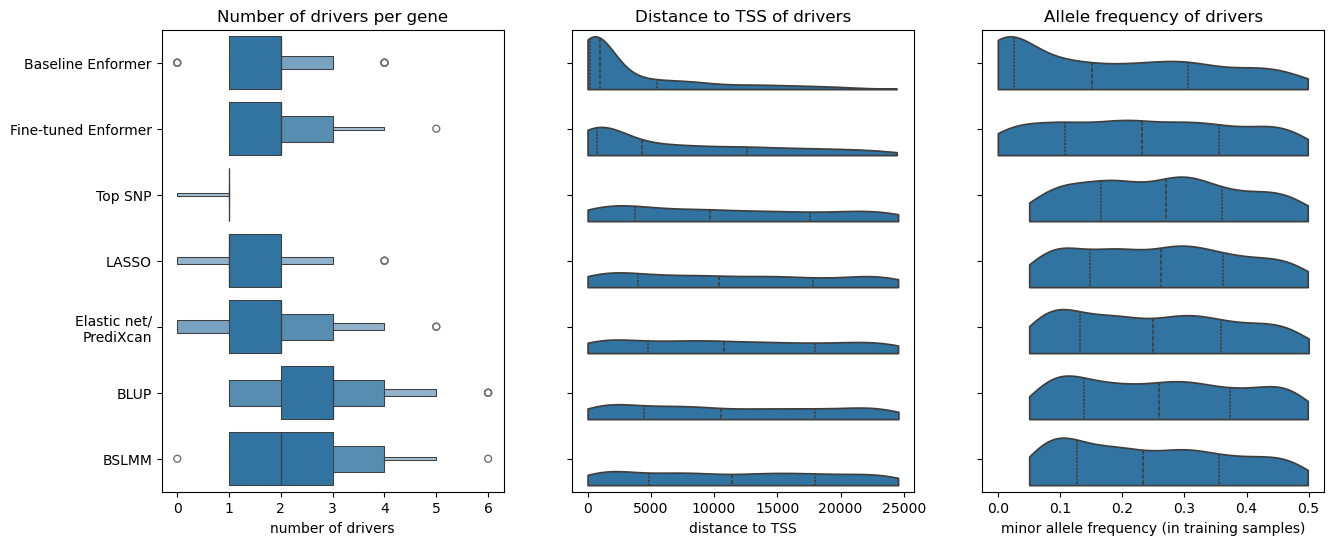

In [41]:
plot_results(
    results_df, training_genes, savepath=os.path.join(FIGURES_DIR, "drivers.pdf")
)

In [43]:
results_df.to_csv("drivers.csv", index=False)